In [ ]:
!pip install kaggle
#!pip install gradio

from google.colab import drive
from google.colab import files


drive.mount('/content/drive')
files.upload()

kaggle_dataset_path = '/content/drive/MyDrive/pattern_recognition/HM2'
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews -p {kaggle_dataset_path}
!unzip {kaggle_dataset_path}/imdb-dataset-of-50k-movie-reviews.zip -d {kaggle_dataset_path}


!ls
#!pwd

Total samples: 50000
Training samples: 40000
Testing samples: 10000
Original class distribution:
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64

Training set class distribution:
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64

Testing set class distribution:
sentiment
0    0.5
1    0.5
Name: proportion, dtype: float64
Number of unique words: 185922
17
OOV token index: 1
(40000, 300)
(10000, 300)
[   10  1014    11   116  1463   438    32  1599   142     8    39    10
    13    30     4  8483  1618     6    64   107   169   652   880    90
     2  1618    13  3250   369     3    15    53  1828    34  1170     4
   716     5   880   332  7672     6    75   170     8     2  1191    85
    65   632  1116    18    11   362    20     3   722  1570     2   308
    13     8 17254     2  1058   431   362    51    34  1170  2693     1
   261   602     1     1   297     5  1135    20    41   417    58   274
    30     2   370   394     4  3194  1838     3 10136    12   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model, tokenizer, and max_seq_length have been saved successfully.
313/313 [==============================] - 19s 58ms/step

Test loss: 0.4617

Test accuracy: 0.7880
              precision    recall  f1-score   support

    Negative       0.94      0.61      0.74      5000
    Positive       0.71      0.96      0.82      5000

    accuracy                           0.79     10000
   macro avg       0.83      0.79      0.78     10000
weighted avg       0.83      0.79      0.78     10000

1/1 [==============================] - 0s 72ms/step

positive sample result: Positive
1/1 [==============================] - 0s 69ms/step

negative sample result: Negative
1/1 [==============================] - 0s 80ms/step

ambiguous sample result: Positive


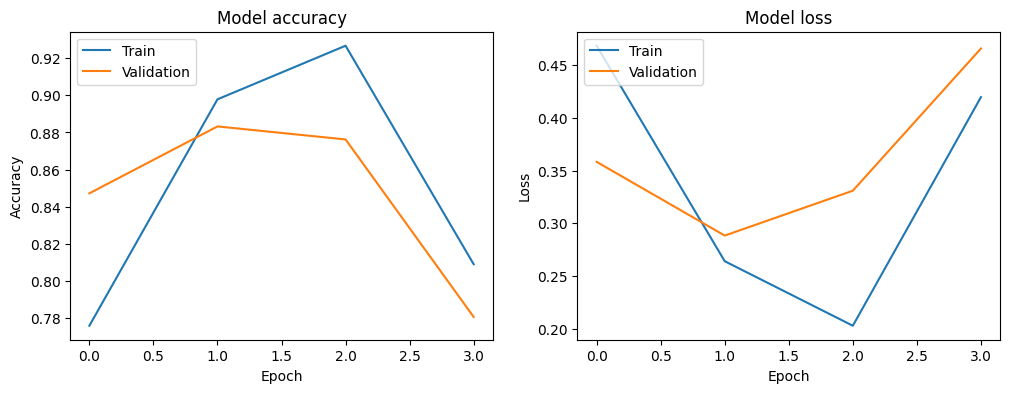

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# base libs
import numpy as np
import pandas as pd

# data preprocessing libs
import re
import string

# model building libs
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# building UI libs
# import gradio as gr

# data splitting and model building libs
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# report lib
from sklearn.metrics import classification_report

# for saving and loading the tokenizer
import pickle

# early training stop
from tensorflow.keras.callbacks import EarlyStopping

import os


early_stop = EarlyStopping(monitor='val_loss', patience=2)


dataset_path = '/content/drive/MyDrive/pattern_recognition/HM2/IMDB Dataset.csv'
drive_project_path = '/content/drive/MyDrive/pattern_recognition/HM2/output/'
os.makedirs(drive_project_path, exist_ok=True)

df = pd.read_csv(dataset_path)

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned review'] = df['review'].apply(clean_text)

# df.head()

X = df['cleaned review']
y = df['sentiment'].map({'negative': 0, 'positive': 1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

###################
print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

print("Original class distribution:")
print(y.value_counts(normalize=True))

print("\nTraining set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nTesting set class distribution:")
print(y_test.value_counts(normalize=True))
##################

# init the Tokenizer
number_of_words = 20000
tokenizer = Tokenizer(num_words=number_of_words, oov_token='<OOV>')
# fit the tokenizer on the training data
tokenizer.fit_on_texts(X_train)

# vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
# print("Vocabulary Size:", vocab_size)
vocab_size = number_of_words

##################
word_index = tokenizer.word_index
print("Number of unique words:", len(word_index))
print(word_index['movie'])
print(f"OOV token index: {tokenizer.word_index['<OOV>']}")
#################

# text -> seq
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# determine the max seq leng
# max_sequence_length = max(len(seq) for seq in X_train_sequences)
# seq_lengths = [len(seq) for seq in X_train_sequences]
# max_seq_length = int(np.percentile(seq_lengths, 95))
max_seq_length = 300


###################
# print("Max sequence length:", max_sequence_length)
# print("95th percentile sequence length:", np.percentile(seq_lengths, 95))
####################

# pad the seq
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_seq_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_seq_length, padding='post', truncating='post')

##############
print(X_train_padded.shape)
print(X_test_padded.shape)
print(X_train_padded[0])
print(len(X_train_padded[0]))
############



# Calculate the percentage of OOV tokens in the training sequences
total_tokens = sum(len(seq) for seq in X_train_sequences)
oov_token_index = tokenizer.word_index[tokenizer.oov_token]
oov_tokens = sum(seq.count(oov_token_index) for seq in X_train_sequences)

oov_percentage = (oov_tokens / total_tokens) * 100
print(f"Percentage of OOV tokens in training data: {oov_percentage:.2f}%")


# define the model
model =Sequential()

# add an embedding layer
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_shape=(max_seq_length,)))

# add an LSTM layer
model.add(Bidirectional(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2)))

# add a dense output layer with sigmoid activation for binary classification
model.add(Dense(units=1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


# train the model
history = model.fit(
    X_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop]
)
history_dic = history.history
print(f"\nTraining history: {history_dic.keys()}")


# After training the model

# Save the model
model_save_path = os.path.join(drive_project_path, 'sentiment_analysis_model.h5')
model.save(model_save_path)

# Save the tokenizer
tokenizer_save_path = os.path.join(drive_project_path, 'tokenizer.pickle')
with open(tokenizer_save_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save max_seq_length
max_seq_length_save_path = os.path.join(drive_project_path, 'max_seq_length.pickle')
with open(max_seq_length_save_path, 'wb') as handle:
    pickle.dump(max_seq_length, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Model, tokenizer, and max_seq_length have been saved successfully.")


# evaluate the model
loss, accuracy = model.evaluate(X_test_padded, y_test)
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)
print(f"\nTest loss: {loss:.4f}")
print(f"\nTest accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))


# Testing the model
# function to preprocess and predict sentiment
def predict_sentiment(review):
    # clean the review
    cleaned_review = clean_text(review)
    # convert to sequence
    review_sequence = tokenizer.texts_to_sequences([cleaned_review])
    # pad the sequence
    review_padded = pad_sequences(review_sequence, maxlen=max_seq_length, padding='post', truncating='post')
    # predict sentiment
    prediction = model.predict(review_padded)[0][0]
    # return the sentiment
    if prediction > 0.5:
        return "Positive"
    else:
        return "Negative"

# example review
# positive sample
sample_review = "This movie was fantastic! I loved every minute of it."
print(f'\npositive sample result: {predict_sentiment(sample_review)}')
# negative sample
sample_review = "This movie was terrible. I hated every minute of it."
print(f'\nnegative sample result: {predict_sentiment(sample_review)}')
# ambiguous sample
sample_review = "This movie was okay. I liked it a bit."
print(f'\nambiguous sample result: {predict_sentiment(sample_review)}')





import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()